| 文件名               | 有效行范围  | 样本数 | 是否有标签         | 与训练集分布是否一致 | 作用                         | 使用场景                             | 是否参与打分 |
|----------------------|-------------|--------|----------------------|------------------------|------------------------------|--------------------------------------|----------------|
| X_train.csv          | 2–10001     | 10,000 | 有，对应 y_train.csv | 是                  | 特征矩阵                    | 模型训练                             | ❌ 否         |
| y_train.csv          | 2–10001     | 10,000 | 有，对应 X_train     | 是                  | 训练集标签                  | 模型训练                             | ❌ 否         |
| X_test_1.csv         | 2–1001      | 1000   | ❌ 无标签             | 是                  | 第一份测试集                | 对模型进行评分（同分布性能）         | 是         |
| X_test_2.csv         | 2–2021      | 2020   | 部分有（前202）      | ❌ 否（分布发生变化）  | 第二份测试集，含偏移分布数据 | 前202行为新分布评估，后1818行需预测 | ✅（后1818行）|
| y_test_2_reduced.csv | 2–203       | 202    | 有，对应 X_test_2[2:203] | ❌ 否（新分布标签）   | 新分布小规模标签子集        | 评估模型在未知/偏移分布下的表现     | ❌ 否         |


In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv").squeeze()

In [3]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.617940,-0.391980,0.13278,0.032551,0.55201,0.83393,-0.837550,-0.874060,0.43930,0.268260,...,-0.45454,0.36452,1.575300,-0.620320,-0.25371,-0.447750,-0.038273,-0.019938,-0.195500,0.428830
1,0.333860,-1.549100,1.67050,0.793560,0.80251,-0.07206,-0.068276,3.302400,0.52045,0.685720,...,-0.36913,1.74080,1.286600,-0.013396,-1.53930,0.833540,0.472610,0.513030,-0.743140,1.219900
2,0.040399,-0.608070,1.62080,-0.355970,0.12105,1.35250,0.373200,1.111700,0.35894,-0.344100,...,-1.40230,-0.24763,0.507050,0.708220,-0.60083,0.911040,0.009979,-0.475990,-0.094731,-0.008521
3,1.723600,0.195290,1.03880,-3.009100,-0.33222,0.91067,0.666690,0.717250,3.05850,1.489900,...,-1.21540,-0.25284,-1.307800,-0.445660,0.27918,0.264670,-0.149360,1.492900,-1.176700,-1.854500
4,-1.032300,1.900100,-1.46010,0.383710,-0.51039,0.74481,-0.914660,-0.865880,-0.34426,0.869650,...,1.32230,0.06020,-1.079000,-0.617050,1.18450,-0.210630,-0.105870,-0.412040,1.409700,0.133350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.821000,-0.016804,0.36978,-1.652500,1.32370,-0.67655,-1.238000,-0.764210,0.16283,-0.240030,...,-1.25470,-0.76602,1.453600,1.954500,0.47550,-1.824700,-0.227030,1.879700,-1.123800,1.309600
9996,-0.636390,-0.403470,0.81521,-0.665990,-2.16210,2.03190,0.278910,0.169180,0.52821,-0.217570,...,0.42273,-0.07438,-0.958710,-0.030666,-0.43114,0.075285,-0.892370,-0.677320,-1.330200,-0.809090
9997,0.773410,0.157330,-0.82969,-2.569100,1.33060,-0.45354,0.154800,0.010011,0.79613,0.606680,...,-1.15410,-1.75520,-1.645100,0.316050,-0.49966,0.997910,-1.389800,0.773250,0.049626,-0.500440
9998,-0.382970,1.011900,-2.12320,1.385600,0.30195,-0.45940,-0.050270,0.591280,1.49210,0.012371,...,0.24839,0.20263,0.010861,-0.775840,-0.98314,0.216800,1.323800,0.450360,1.586200,-0.289050


In [4]:
y_train

0       10
1        5
2        5
3        5
4        5
        ..
9995    19
9996     5
9997    17
9998    24
9999     5
Name: label, Length: 10000, dtype: int64

In [5]:
class_counts = y_train.value_counts()

class_counts

label
5     4479
10    1081
6      553
8      516
12     457
24     385
17     354
26     278
21     269
14     264
4      238
25     184
19     177
20     153
27     107
7      103
11      78
3       65
13      62
18      60
23      41
15      26
9       25
0       18
2        7
22       7
1        7
16       6
Name: count, dtype: int64

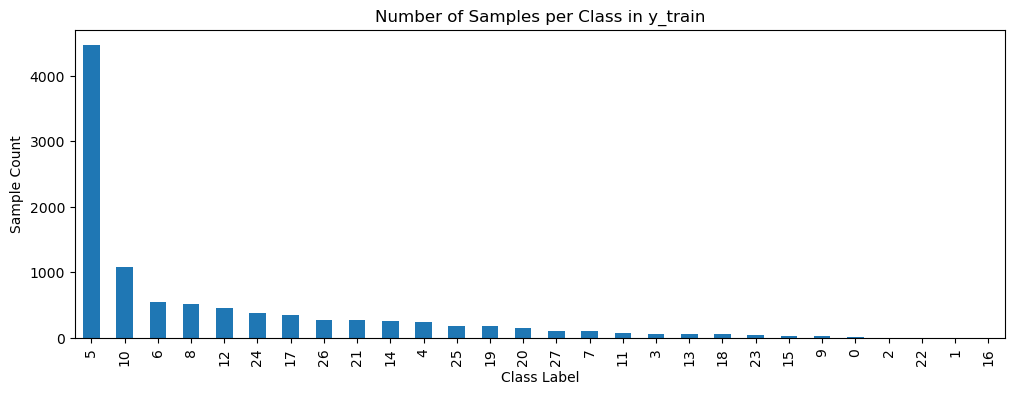

In [6]:
class_counts.plot(kind='bar', figsize=(12, 4))
plt.title("Number of Samples per Class in y_train")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.show()

我们对训练集的标签分布进行了可视化分析，结果显示存在严重的类别不平衡现象：

- 第 5 类的样本数量超过 4000，占据主导地位；

- 多个类别（如 0, 1, 2, 16）样本数量甚至不足 10 个。

这将导致模型在训练过程中强烈偏向多数类，从而在整体准确率看似较高的情况下，**对少数类几乎无法正确预测**。这类情况会严重影响模型的泛化能力和实际应用价值。

我们可以采取以下应对策略：

- 在数据划分时使用 **Stratified Sampling** 保证训练/验证集中类别比例一致；

- 在模型中设置 `class_weight='balanced'`，提升少数类在损失函数中的权重；

- 在评估阶段引入 **macro-F1 score、precision、recall** 等更加公平的指标；

- 后续可进一步引入 **Oversampling（如 SMOTE）** 或 **集成方法（如 Bagging, Boosting）**，增强模型在小样本类别上的表现。

总之，在极度不平衡的多分类任务中，**不能单纯依赖准确率来评价模型性能**，更应注重各类样本的平均表现和召回能力。

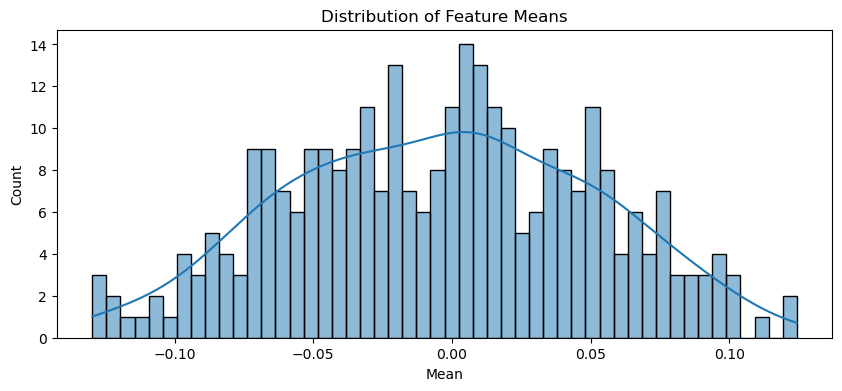

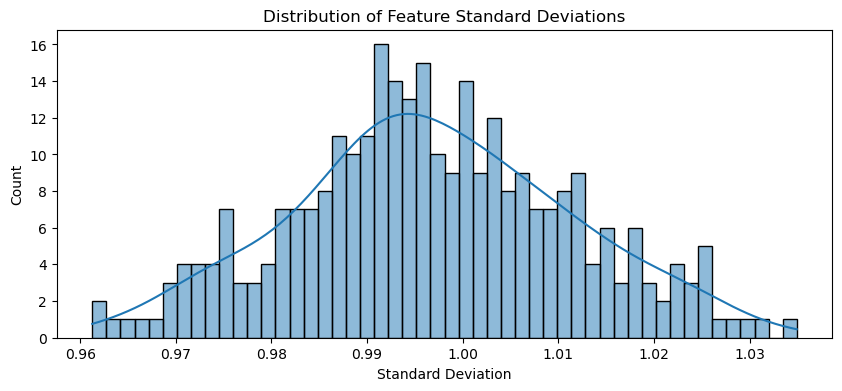

In [7]:
# 特征分布

# 绘制各特征的均值和 stds 分布图
means = X_train.mean(axis=0)
stds = X_train.std(axis=0)

plt.figure(figsize=(10, 4))
sns.histplot(means, bins=50, kde=True)
plt.title("Distribution of Feature Means")
plt.xlabel("Mean")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(stds, bins=50, kde=True)
plt.title("Distribution of Feature Standard Deviations")
plt.xlabel("Standard Deviation")
plt.show()


大多数特征的中心大致为 0

大多数特征维度的标准差接近 1，且变化范围较小

这也是归一化嵌入的预期结果。没有发现明显的异常值。

| 特征类型             | 特点                        | 说明                           |
|----------------------|-----------------------------|--------------------------------|
| Word2Vec / GloVe     | 均值接近 0，std 接近 1       | 通常为 dense embedding，已标准化处理 |
| TF-IDF               | 标准差分布不集中，偏态明显   | 各维度受词频影响，常有稀疏性和偏态 |
| One-hot              | 大量 0 和少量 1，均值远离 0   | 高度稀疏，不具备连续值结构       |

通过绘制 300 个嵌入特征维度的均值与标准差分布图，我们发现大多数维度的均值集中在 0 附近，标准差接近 1，整体呈现出正态分布形态。

这一统计特征与 Word2Vec 或 GloVe 等预训练词向量高度一致，说明当前特征极有可能来源于已归一化的密集型嵌入模型。

这类特征可直接用于下游分类建模，**无需进一步归一化处理**，且在高维空间中具有较好的几何结构，有助于模型学习出有效的判别边界。

In [8]:
# 选取样本数 >= 100 的类
selected_classes = class_counts[class_counts>=100].index.tolist()
selected_classes

[5, 10, 6, 8, 12, 24, 17, 26, 21, 14, 4, 25, 19, 20, 27, 7]

现在，我们需要观察在高维嵌入空间中，各类别是否具有明显的聚集结构（是否能被区分开）

我们想人为选了样本数 ≥ 100 的类别（ 5, 6, 8, 10...），并对每个类采样最多 100 个样本，然后画出：

- 每个点的 PCA 映射值（PC1, PC2）

- 每个点的颜色表示所属类别

In [9]:
# 对这些类做每类100个样本的平衡采样
X_balanced = []
y_balanced = []

for cls in selected_classes:
    X_cls = X_train[y_train == cls]
    y_cls = y_train[y_train == cls]
    # 若不足100个就全选，否则采样100个
    n = min(100, len(X_cls))
    X_sampled = X_cls.sample(n=n, random_state=42)
    y_sampled = y_cls.loc[X_sampled.index]
    X_balanced.append(X_sampled)
    y_balanced.append(y_sampled)

X_balanced = pd.concat(X_balanced)
y_balanced = pd.concat(y_balanced)

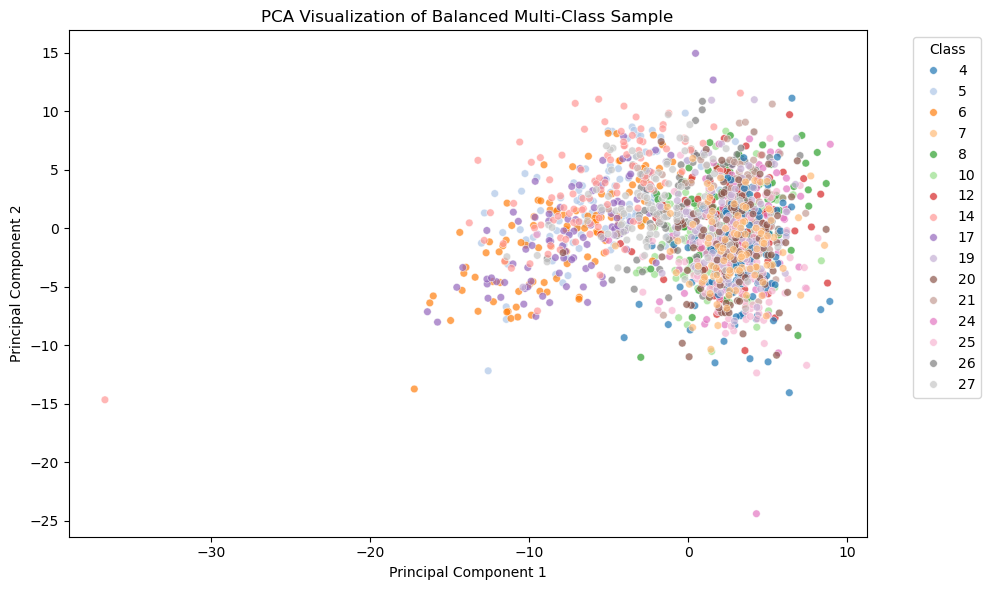

In [10]:
# PCA 降维 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_balanced)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["label"] = y_balanced.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="label", palette="tab20", s=30, alpha=0.7)
plt.title("PCA Visualization of Balanced Multi-Class Sample")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

虽然大多数类别之间存在重叠，但也存在一些聚类。

这表明嵌入式包含了分类器可以利用的结构。

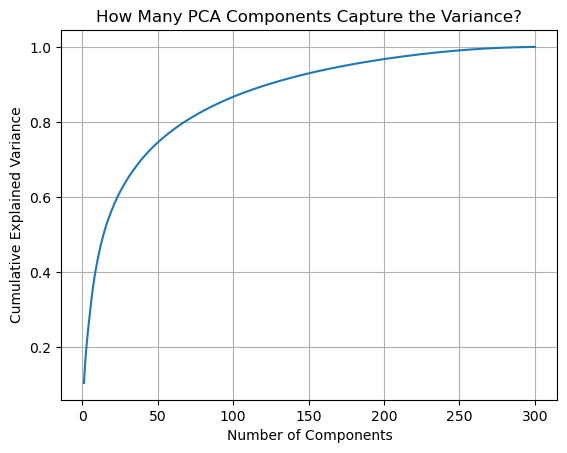

In [11]:
# 每个主成分保留了多少信息（方差解释率）

pca = PCA(n_components=300)
pca.fit(X_train)

explained_variance_ratio = pca.explained_variance_ratio_

plt.plot(range(1, 301), explained_variance_ratio.cumsum())
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("How Many PCA Components Capture the Variance?")
plt.grid(True)
plt.show()


使用 PCA 对多个类别的嵌入特征进行了降维可视化，我们发现虽然多数类样本在二维空间中有重叠，但部分类别形成了局部聚集，说明特征中包含一定的可分结构。

此外，我们绘制了累计解释方差曲线，**发现前 100 个主成分即可保留超过 90% 的数据方差信息**，说明原始 300 维嵌入向量存在冗余特征。

结合两者结果，我们认为嵌入特征具备一定的判别能力，但需要配合非线性模型建模，并可考虑进行降维以简化模型复杂度。

现在，我们想精确找出对分类任务最有预测价值的特征维度，也就是 我们有 300 个 embedding 维度，想知道哪几个维度在划分 28 个类别时最有用。

但是，我们并不知道这些 embedding 的含义（没有语义标签），不能通过人工规则挑选特征，只能靠模型去“学习”哪些维度对分类最关键。

我们可以选用 RF 来做，原因有以下方面

| 原因                     | 说明                                                                 |
|----------------------------|----------------------------------------------------------------------|
| 内置特征重要性评估       | 每棵树在训练时记录了特征的“分裂贡献度”，训练后可直接用 `.feature_importances_` 输出每一维的评分 |
| 能处理多类分类任务       | 本任务包含 28 个类别，随机森林天然支持多分类问题                               |
| 非线性建模能力强         | 可自动捕捉嵌入向量中各维度之间复杂的非线性关系，评估更加全面                      |
| 对高维数据鲁棒           | 即使存在大量冗余特征，也不会影响模型性能，重要维度仍能被识别出                       |
| 无需特征标准化处理       | 对 embedding 类特征非常友好，无需归一化即可直接训练                                 |


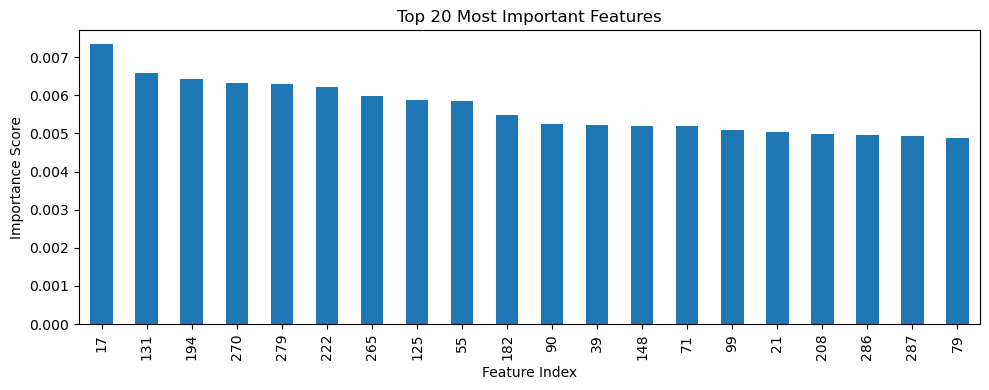

In [12]:
# Feature Importance Analysis

from sklearn.ensemble import RandomForestClassifier

# 使用原始训练集训练模型
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 提取特征重要性
importances = pd.Series(model.feature_importances_, index=[f"{i}" for i in range(X_train.shape[1])])
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 4))
top_features.plot(kind='bar')
plt.title("Top 20 Most Important Features")
plt.ylabel("Importance Score")
plt.xlabel("Feature Index")
plt.tight_layout()
plt.show()


特征维度编号 17, 131, 194, 270, 279 等，它们是模型最依赖的维度，用于划分不同类别，这些维度包含了对多个类别具有显著区分度的信息

虽然 feature_17 得分最高，但重要性差距不大，前 20 个维度得分都集中在 0.0045 ~ 0.0073 之间，这说明，这些维度虽然比其他重要，但差距不极端，模型可能依赖多个维度的组合

实际上大多数维度的 importance 得分非常低（未显示），说明原始 300 维嵌入中有较多冗余维度，这与之前 PCA 发现的一致（前 100 维就能解释 90% 信息）

为了验证 Accuracy 与 F1 分数在不同分布下的表现，我们思考以下问题：

- Accuracy 是否能稳定、可靠地反映模型性能？

- 在类别不平衡或分布变化的情况下，是否会产生误导？

**第一组实验：验证集来自 X_train 内部划分（旧分布）**

我们将 `X_train.csv` 与 `y_train.csv` 按照 8:2 的比例进行 stratified 划分，得到训练集与验证集。

由于它们来源一致，类别分布相近，因此模型容易泛化到验证集。

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# 划分训练/验证集
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 训练模型
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_tr, y_tr)


y_val_pred = model.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='macro')
print(f"验证集（原始分布） Accuracy: {acc_val:.4f}, Macro F1: {f1_val:.4f}")


验证集（原始分布） Accuracy: 0.6705, Macro F1: 0.2255


Accuracy = **0.6705**（较高）

Macro F1 = **0.2255**（相对较低）

这说明模型**主要预测了多数类**，虽然整体预测对得多，但**对小类几乎无识别能力**，F1 分数暴露了这个问题。

当训练集和测试集的分布不一致时（P_train(x) ≠ P_test(x)），模型在训练集上学到的规律无法泛化到测试集 --- 这就是 Domain Shift。

如果 test2 的数据集中在训练集未充分覆盖的区域，模型性能会下降

若仍使用 Accuracy，可能因为“多数类猜对了”而产生虚高，误判模型很好

所以我们先分析，是否存在 Domain Shift，我们还是选择 PCA

因为 面对的是一个300维的高维嵌入特征空间，直接用肉眼无法理解样本在空间中如何分布

我们可以 用PCA 将高维空间中样本之间的相似性关系投影到 2D 或 3D 平面中，保留尽可能多的全局结构与方差

观测不同数据来源（train vs test）是否具有分布重叠性或偏移

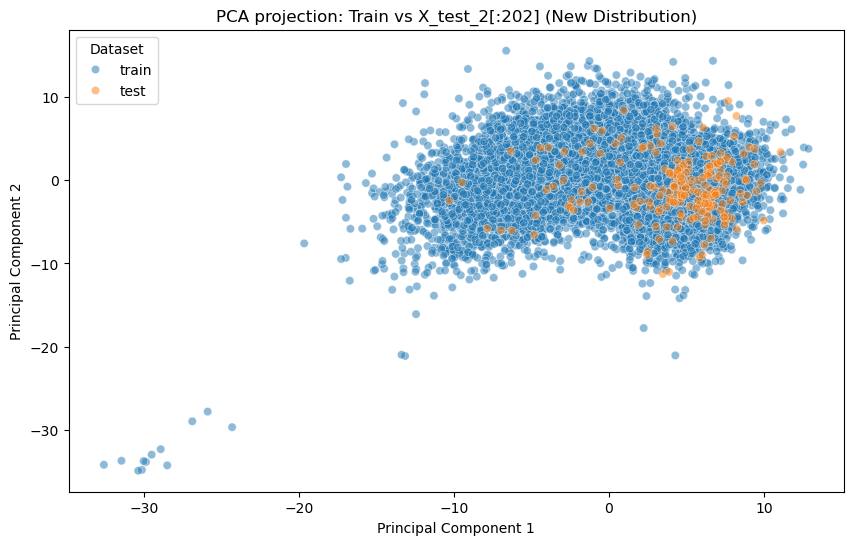

In [14]:
X_test2 = pd.read_csv("data/X_test_2.csv").reset_index(drop=True)
X_test2_labeled = X_test2.iloc[:202] # The labeled part of X_test2

combined = pd.concat([X_train, X_test2_labeled])
labels = ["train"] * len(X_train) + ["test"] * len(X_test2_labeled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(combined)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = labels

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", alpha=0.5)
plt.title("PCA projection: Train vs X_test_2[:202] (New Distribution)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Dataset")
plt.show()

从图中我们可以看到

浅蓝色（训练集）分布较广，覆盖多个区域

橙色（test2前202条）集中在 PCA 右上角某一密集区域

说明 test2 的样本分布存在偏移，模型未必在这个区域训练充分 -> 泛化差

**第二组实验：验证集换为 `X_test_2[:202]`（新分布）**

我们在同一个模型在其上进行预测

In [15]:
y_test2 = pd.read_csv("data/y_test_2_reduced.csv").squeeze().reset_index(drop=True)

y_test2_pred = model.predict(X_test2_labeled)
acc_test2 = accuracy_score(y_test2, y_test2_pred)
f1_test2 = f1_score(y_test2, y_test2_pred, average='macro')
print(f"Test2[:202] Accuracy: {acc_test2:.4f}, Macro F1: {f1_test2:.4f}")


Test2[:202] Accuracy: 0.3218, Macro F1: 0.1930


Accuracy = **0.3218**（显著下降）

Macro F1 = **0.1930**（仍然很低）

此时 Accuracy 本身也下降了，因此**并未产生“误导”模型表现的错觉**，但我们仍观察到 F1 更能揭示出小类识别能力不足。
